In [56]:
import json
import pandas as pd

# Load datasets

In [2]:
rubq = json.load(open('../data/preprocessed/rubq/rubq_train.json'))['dataset']
qald = json.load(open('../data/preprocessed/qald/qald_train.json'))['dataset']
pat = json.load(open('../data/preprocessed/pat/pat_train.json'))['dataset']
lcquad = json.load(open('../data/preprocessed/lcquad_2.0/lcquad_2.0_train.json'))['dataset']

In [3]:
relations_info = json.load(open('storage/wikidata_relations_info.json'))

In [26]:
rel_stats = {}

for item in rubq:
    for rel_id in item['relations']['query'].keys():
        rel_stats[rel_id] = rel_stats.get(rel_id, []) + [item['en_question']]

# Embeddings

In [33]:
from sentence_transformers import SentenceTransformer
import numpy as np

In [89]:
class SentenceRelationLinker:
    def __init__(self, rel_stats):
        self.st_model = SentenceTransformer('all-mpnet-base-v2')
        
        self.rel_embeddings = {}
        for rel_id, sents in rel_stats.items():
            self.rel_embeddings[rel_id] = self.avg_sentence_embedding(sents)

    
    def avg_sentence_embedding(self, sentences):
        embeddings = self.st_model.encode(sentences, convert_to_tensor=False)  # as numpy array
        return np.mean(embeddings, axis=0)
        
    def top_k_similar_ids(self, new_sentence, k=2):
        new_emb = self.avg_sentence_embedding([new_sentence])
        scores = {}
        for rel_id, emb in self.rel_embeddings.items():
            sim = cosine_similarity(new_emb.reshape(1, -1), emb.reshape(1, -1))[0, 0]
            scores[rel_id] = sim
        sorted_ids = sorted(scores, key=lambda id_: scores[id_], reverse=True)
        return sorted_ids[:k]

### Fit

In [83]:
rubq = json.load(open('../data/preprocessed/rubq/rubq_train.json'))['dataset']
qald = json.load(open('../data/preprocessed/qald/qald_train.json'))['dataset']
pat = json.load(open('../data/preprocessed/pat/pat_train.json'))['dataset']
lcquad = json.load(open('../data/preprocessed/lcquad_2.0/lcquad_2.0_train.json'))['dataset']

rel_stats = {}

for item in rubq:
    for rel_id in item['relations']['query'].keys():
        rel_stats[rel_id] = rel_stats.get(rel_id, []) + [item['en_question']]

for item in qald:
    for rel_id in item['relations']['query'].keys():
        rel_stats[rel_id] = rel_stats.get(rel_id, []) + [item['en_question']]

for item in pat:
    for rel_id in item['relations']['query'].keys():
        rel_stats[rel_id] = rel_stats.get(rel_id, []) + [item['en_question']]

for item in lcquad:
    for rel_id in item['relations']['query'].keys():
        rel_stats[rel_id] = rel_stats.get(rel_id, []) + [item['en_question']]

In [90]:
linker = SentenceRelationLinker(rel_stats)

### Validate

In [109]:
def calculate_metircs(dataset, relation_linker):
    tp, fp, fn = 0, 0, 0
    
    for item in tqdm(dataset):
        actual = set(item['relations']['query'].keys())
        predicted = set(relation_linker(item['en_question']))

        tp += len(predicted & actual)  # True Positives
        fp += len(predicted - actual)  # False Positives
        fn += len(actual - predicted) # False Negatives

    confusion_matrix = pd.DataFrame(
        [[tp, fp], [fn, tn]],
        columns=["Positive", "Negative"],
        index=["True", "False"]
    )

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    accuracy = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

    return {
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
    }, confusion_matrix


In [124]:
rubq_test = json.load(open('../data/preprocessed/rubq/rubq_test.json'))['dataset']
qald_test = json.load(open('../data/preprocessed/qald/qald_test.json'))['dataset']
pat_test = json.load(open('../data/preprocessed/pat/pat_test.json'))['dataset']
lcquad_test = json.load(open('../data/preprocessed/lcquad_2.0/lcquad_2.0_test.json'))['dataset']

datasets = {
    'rubq': rubq_test,
    'qald': qald_test,
    'lcquad_2.0': lcquad_test,
    'pat': pat_test
}

# results = {}

# for k in [1, 2, 3, 5, 10, 15, 20]:
#     table = pd.DataFrame(columns=['f1', 'precision', 'recall', 'accuracy'])
#     relation_linker = lambda sentence: linker.top_k_similar_ids(sentence, k=k)
#     for dataset_name, dataset in datasets.items():
#         metrics, _ = calculate_metircs(dataset, relation_linker)
#         table.loc[dataset_name]= pd.Series(metrics)

#     results[k] = table

100%|███████████████████████████████████████| 1199/1199 [07:55<00:00,  2.52it/s]


In [145]:
results[20]

,f1,precision,recall,accuracy
rubq,0.083992,0.044271,0.817308,0.043837
qald,0.098654,0.053627,0.615156,0.051886
lcquad_2.0,0.108890,0.058930,0.715412,0.057580
pat,0.251538,0.144037,0.991674,0.143863


In [143]:
relation_linker = lambda sentence: linker.top_k_similar_ids(sentence, k=10)

relation_linker('What is the capital of France?')

['P36', 'P1376', 'P17', 'P630', 'P47', 'P3963', 'P131', 'P466', 'P150', 'P669']

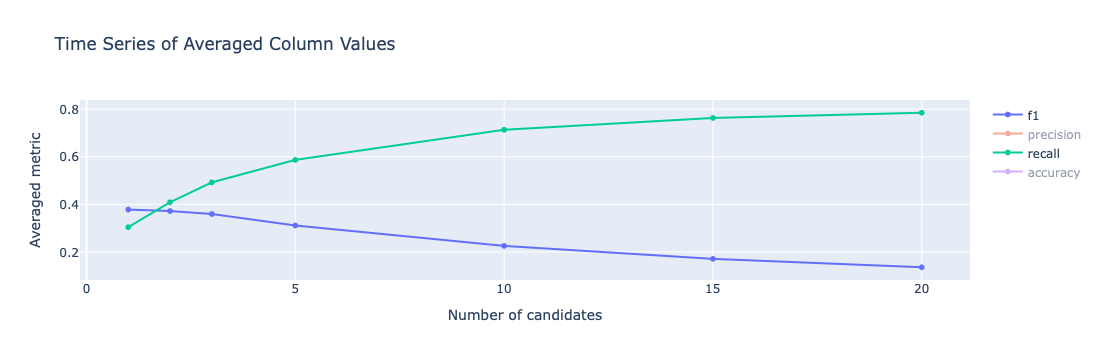

In [140]:
import plotly.graph_objects as go

aggregated_data = {key: df.mean(axis=0) for key, df in results.items()}
df_plot = pd.DataFrame(aggregated_data).T 

fig = go.Figure()
for column in df_plot.columns:
    fig.add_trace(go.Scatter(x=df_plot.index, y=df_plot[column], mode='lines+markers', name=column))

# Update layout
fig.update_layout(
    title="Time Series of Averaged Column Values",
    xaxis_title="Number of candidates",
    yaxis_title="Averaged metric",
)

fig.show()